In this notebook, we model the main dataframe (main_df) by looking at a discretization of wageloss and using a decision tree classifier to categorize each datapoint into a wage change tier.

# Imports and useful functions

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix

# Downloading main dataframe


In [3]:
df = pd.read_csv('../data/main_df.csv')

In [4]:
df.shape

(1566063, 15)

In [95]:
df.isna().sum().sum()

0

In [96]:
df = df.astype({'year':'str','month':'str'}).copy()

In [97]:
df['y_m'] = df['year']+df['month']

In [98]:
df['y_m'] = pd.to_datetime(df['y_m'],format = '%Y%m')

ValueError: time data '1997.011.0' does not match format '%Y%m' (match)

In [15]:
# Set Date to be in the index
df.set_index('y_m', inplace=True)

In [82]:
# Sort the index
df.sort_index(inplace = True)
df.head(3)

,disasterNumber,state,incidentType,year,month,occ_code,occ_title,tot_emp,h_mean,a_mean,employment_rate_during,employment_rate_before,employment_rate_after,employment_rate_change,wage_change
y_m,,,,,,,,,,,,,,,
1997-01-01,1159,WA,Severe Storm(s),1997,1,58014,"Meter Readers, Utilities",600.0,14.52,30210,65.4,65.3,65.8,-0.5,-20908.800
1997-01-01,1155,CA,Severe Storm(s),1997,1,85953,Tire Repairers and Changers,7290.0,8.66,18020,61.5,61.5,61.7,-0.2,-60606.144
1997-01-01,1155,CA,Severe Storm(s),1997,1,85956,"Menders, Garments, Linens, and Related",840.0,8.95,18610,61.5,61.5,61.7,-0.2,-7217.280


The first two digits of the occupation code ('occ_code') can be used to identify the industry that each occupation belongs to. We create a new column ('business_type') with this information so that we can model just one industry at a time (rather than all 1.5 million datapoints at a time). 

Code for creating the business type was created by Patrick Kajibale.

In [5]:
df['Business_type']= df['occ_code'].apply(lambda x : x[:2])

In [6]:
df['Business_type'].value_counts

<bound method IndexOpsMixin.value_counts of 0          13
1          13
2          13
3          13
4          13
           ..
1566058    53
1566059    53
1566060    53
1566061    53
1566062    53
Name: Business_type, Length: 1566063, dtype: object>

In [7]:
# Creating more generic job title
# written by Patrick Kajibale

df['Business_type']= df['occ_code'].apply(lambda x : x[:2])
#pd.set_option('display.max_row()',None)
industry = {
        '13' :'Business and Financial Operations',
        '15' :'Computer and Mathematical',
        '17' :'Architecture and Engineering',
        '19' :'Life, Physical, and Social Science',
        '21' :'Community and Social Service',
        '23' :'Legal',
        '25' :'Educational Instruction and Library',
        '27' :'Arts, Design, Entertainment, Sports, and Media',
        '29' :'Healthcare Practitioners and Technical',
        '31' :'Healthcare Support',
        '33' :'Protective Service',
        '35' :'Food Preparation and Serving Related',
        '37' :'Building and Grounds Cleaning and Maintenance',
        '39' :'Personal Care and Service',
        '41' :'Sales and Related',
        '43' :'Office and Administrative Support',
        '45' :'Farming, Fishing, and Forestry',
        '47' :'Construction and Extraction',
        '49' :'Installation, Maintenance, and Repair',
        '51' :'Production',
        '53' :'Transportation and Material Moving'}
df['Business_type'].replace(industry, inplace = True)


In [1]:
# how many industries are included in the data?
len(industry)

NameError: name 'industry' is not defined

In [20]:
industries = industry.values()

Examining histograms of the wage change across each industry to compare their spread:


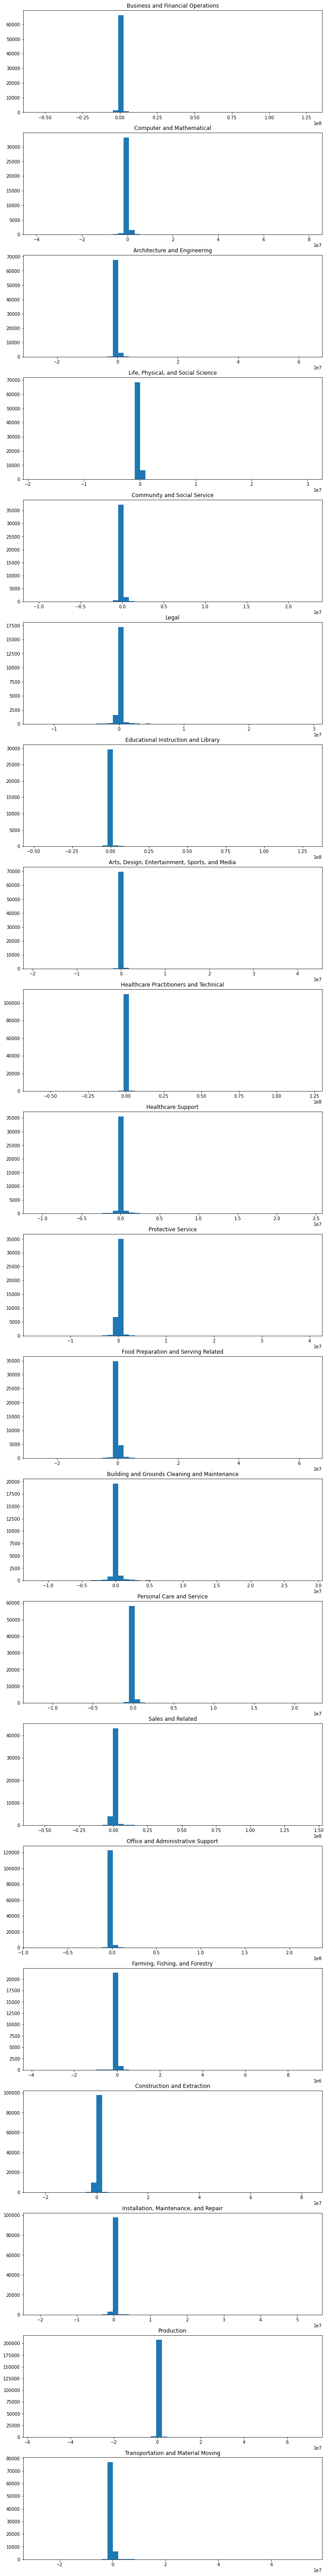

In [22]:
fig, axes = plt.subplots(nrows=len(industries), figsize=(12, 5 * len(industries)))
for i, name in enumerate(industries):
    # Filter the df to all checks from said dept
    current_df = df.loc[df['Business_type'] == name]
    # Get actual percentages for each first digit
    axes[i].hist(current_df['wage_change'], bins = 50)
    axes[i].set_title(name)

# Food service industry wage change modeling:

In [9]:
food_df = df.loc[df['Business_type'] == 'Food Preparation and Serving Related']


In [27]:
food_df.shape

(41144, 18)

In [13]:
# cutting the food service industry wage changes into bins based on percentile:

food_df['labels'] = pd.qcut(food_df['wage_change'], 
                            [0, .05, .1, .15, .2, .25, .3, .5, .75, .8, .85, .9, .95, 1.])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# baseline accuracy is weight of largest class, so 
# 29%
food_df['labels'].value_counts(normalize=True)

(-15362.4, 0.0]                 0.291902
(0.0, 44906.22]                 0.158030
(-498661.718, -208297.056]      0.050214
(77391.552, 146173.824]         0.050141
(-32541.6, -15362.4]            0.050068
(730222.142, 63061812.0]        0.050019
(44906.22, 77391.552]           0.050019
(-26774001.601, -498661.718]    0.050019
(285932.112, 730222.142]        0.049995
(-58435.085, -32541.6]          0.049995
(-105563.268, -58435.085]       0.049995
(146173.824, 285932.112]        0.049825
(-208297.056, -105563.268]      0.049776
Name: labels, dtype: float64

In [15]:
food_df.head(3)

,disasterNumber,state,incidentType,year,month,occ_code,occ_title,tot_emp,h_mean,a_mean,employment_rate_during,employment_rate_before,employment_rate_after,employment_rate_change,wage_change,Business_type,labels
44065,1360,MS,Severe Storm(s),2001.0,2.0,35-0000,Food Preparation and Serving Related Occupations,84380.0,6.87,14280,59.0,59.2,58.7,0.5,1391257.44,Food Preparation and Serving Related,"(730222.142, 63061812.0]"
44066,1360,MS,Severe Storm(s),2001.0,2.0,35-1011,Chefs and Head Cooks,750.0,12.11,25200,59.0,59.2,58.7,0.5,21798.00,Food Preparation and Serving Related,"(0.0, 44906.22]"
44067,1360,MS,Severe Storm(s),2001.0,2.0,35-1012,First-Line Supervisors/Managers of Food Prepar...,6030.0,9.92,20630,59.0,59.2,58.7,0.5,143562.24,Food Preparation and Serving Related,"(77391.552, 146173.824]"


In [16]:
food_df.dtypes

disasterNumber               int64
state                       object
incidentType                object
year                       float64
month                      float64
occ_code                    object
occ_title                   object
tot_emp                    float64
h_mean                     float64
a_mean                      object
employment_rate_during     float64
employment_rate_before     float64
employment_rate_after      float64
employment_rate_change     float64
wage_change                float64
Business_type               object
labels                    category
dtype: object

In [17]:
food_df['str_labels'] = food_df['labels'].astype('str').copy()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [121]:
food_df['str_labels'].value_counts()

(-15362.4, 0.0]                 12010
(0.0, 44906.22]                  6502
(-498661.718, -208297.056]       2066
(77391.552, 146173.824]          2063
(-32541.6, -15362.4]             2060
(44906.22, 77391.552]            2058
(730222.142, 63061812.0]         2058
(-26774001.601, -498661.718]     2058
(285932.112, 730222.142]         2057
(-58435.085, -32541.6]           2057
(-105563.268, -58435.085]        2057
(146173.824, 285932.112]         2050
(-208297.056, -105563.268]       2048
Name: str_labels, dtype: int64

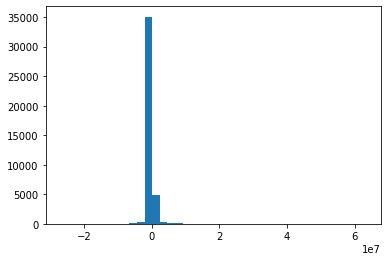

In [90]:
plt.hist(food_df['wage_change'], bins = 40)
;

In [101]:
np.median(food_df['wage_change'])


0.0

In [102]:
# looking at job titles
food_df['occ_title'].unique()

array(['Food Preparation and Serving Related Occupations',
       'Chefs and Head Cooks',
       'First-Line Supervisors/Managers of Food Preparation and Serving Workers',
       'Cooks, Fast Food', 'Cooks, Institution and Cafeteria',
       'Cooks, Restaurant', 'Cooks, Short Order',
       'Food Preparation Workers', 'Bartenders',
       'Combined Food Preparation and Serving Workers, Including Fast Food',
       'Counter Attendants, Cafeteria, Food Concession, and Coffee Shop',
       'Waiters and Waitresses', 'Food Servers, Nonrestaurant',
       'Dining Room and Cafeteria Attendants and Bartender Helpers',
       'Dishwashers',
       'Hosts and Hostesses, Restaurant, Lounge, and Coffee Shop',
       'Food preparation and serving related occupations',
       'Chefs and head cooks',
       'First-line supervisors/managers of food preparation and serving workers',
       'Cooks, fast food', 'Cooks, institution and cafeteria',
       'Cooks, restaurant', 'Cooks, short order',
       '

In [104]:
waiters_df = df.loc[df['occ_title'] == 'Waiters and Waitresses'].copy()

In [105]:
waiters_df['wage_change'].describe()

count    1.478000e+03
mean    -1.529601e+05
std      8.170149e+05
min     -4.840416e+06
25%     -2.567670e+05
50%      0.000000e+00
75%      7.113600e+04
max      5.784066e+06
Name: wage_change, dtype: float64

Plotting the wage change of the inner two quartiles for the food service industry:


In [92]:
short = [x for x in food_df['wage_change'] if (x > -3.254160e+04) & (x < 4.490622e+04)]

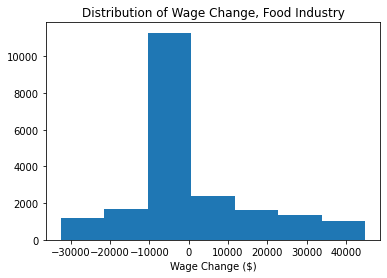

In [138]:
plt.hist(short, bins = 7)
plt.xlabel('Wage Change ($)')
plt.title('Distribution of Wage Change, Food Industry');
plt.savefig('food_dist.png')

In [62]:
food_df['str_labels'].unique()

array(['(730222.142, 63061812.0]', '(0.0, 44906.22]',
       '(77391.552, 146173.824]', '(146173.824, 285932.112]',
       '(44906.22, 77391.552]', '(285932.112, 730222.142]',
       '(-26774001.601, -498661.718]', '(-58435.085, -32541.6]',
       '(-105563.268, -58435.085]', '(-32541.6, -15362.4]',
       '(-208297.056, -105563.268]', '(-15362.4, 0.0]',
       '(-498661.718, -208297.056]'], dtype=object)

In [19]:
# DUMMYING  the state, incident type, and job title

food_df_dum = pd.get_dummies(food_df, 
                             columns = ['state','incidentType','occ_title'], 
                             drop_first = True)



In [20]:
# list of columns which will not be included in the model because they are redundant

features_drop = ['disasterNumber', 
                 'occ_code',
                 'tot_emp',
                 'h_mean',
                 'a_mean',
                 'employment_rate_during',
                 'employment_rate_before',
                 'employment_rate_after', 
                 'employment_rate_change',
                 'wage_change',
                 'Business_type',
                 'labels',
                 'str_labels']


In [21]:
# creating features data (X) and target column (y):

X = food_df_dum.drop(columns = features_drop)
y = food_df['str_labels']

In [22]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                   stratify = y, 
                                                   random_state = 5)


### Decision Tree

In [37]:
dt = DecisionTreeClassifier(random_state = 5,
                            class_weight = 'balanced')

In [24]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=5, splitter='best')

In [25]:
dt.score(X_train, y_train)

1.0

In [26]:
dt.score(X_test, y_test)

0.7268131440793312

Definitely overfit!


In [30]:
cross_val_score(dt, X_train, y_train, cv = 5).mean()

0.6921380848874689

In [38]:
# gridsearch:

dt_params = {
    'max_features' : [None, 4],
    'max_depth' : [None, 10, 20],
    'ccp_alpha' : [0, 1, 10, 0.1, 0.5, 5]
}
gs_dt = GridSearchCV(dt, param_grid = dt_params, cv = 5)

In [39]:
gs_dt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=5, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'ccp_alpha': [0, 1, 10, 0.1, 0.5, 5],
            

In [106]:
gs_dt.best_score_

0.6921380848874689

In [41]:
gs_dt.best_params_

{'ccp_alpha': 0, 'max_depth': None, 'max_features': None}

In [124]:
best_dt = gs_dt.best_estimator_

In [123]:
best_dt.predict(y_test)

ValueError: could not convert string to float: '(730222.142, 63061812.0]'

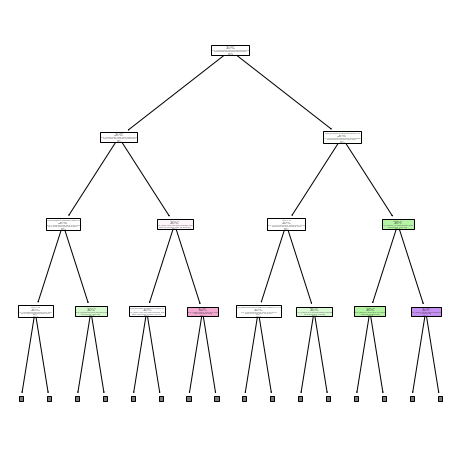

In [135]:
# Import plot_tree from sklearn.tree module.
from sklearn.tree import plot_tree

# Establish size of figure.
plt.figure(figsize = (8, 8))

# Plot our tree.
plot_tree(best_dt,
          max_depth = 3,
          feature_names = X_train.columns,
          class_names = ['a','b','c','d','e','f','g','h','i','j','k','l','m'],
          filled = True);

plt.savefig('food_tree.png')

#### Random Forest

In [43]:
rf = RandomForestClassifier(random_state = 5,
                            class_weight = 'balanced')

In [47]:
# gridsearch:

rf_params = {
    'ccp_alpha' : [0, 1]
}
gs_rf = GridSearchCV(rf, param_grid = rf_params, cv = 5)

In [48]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=5,
                             

In [49]:
gs_rf.best_params_


{'ccp_alpha': 0}

In [50]:
gs_rf.best_score_

0.6978093129562072

In [107]:
preds = gs_rf.predict(X_test)

In [114]:
c_m = confusion_matrix(y_test, preds).ravel()



In [115]:
c_m

array([ 282,   49,   72,    1,   20,   16,   53,    6,    3,    4,    2,
          1,    5,   22, 2671,   17,   27,   62,   21,   45,   76,   13,
          8,   11,   16,   14,   60,   25,  331,    2,    4,   47,   16,
          6,    6,    8,    3,    2,    2,    1,   33,   12,  386,    0,
         31,    0,    1,    0,   12,    0,   38,    1,   20,  127,    4,
          1,  284,    2,   56,   17,    1,    0,    3,    0,    0,   16,
         35,   46,   23,    1,  362,    0,    4,    8,    9,    0,    3,
          9,   79,   75,   12,    1,   60,    1,  262,   12,    0,    1,
         10,    0,    1,    5,  122,    3,    2,   12,    0,    5, 1353,
          7,    3,   79,    2,   32,    2,   25,    8,    4,    1,    7,
          0,   14,  274,   65,   32,    7,   73,    2,   22,    3,   14,
          0,   14,    1,    5,   64,  323,    8,   37,   21,    2,   30,
          6,    2,    4,    0,    3,  131,   27,    7,  229,    2,   72,
          1,   20,    3,   18,    0,    4,    0,   

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

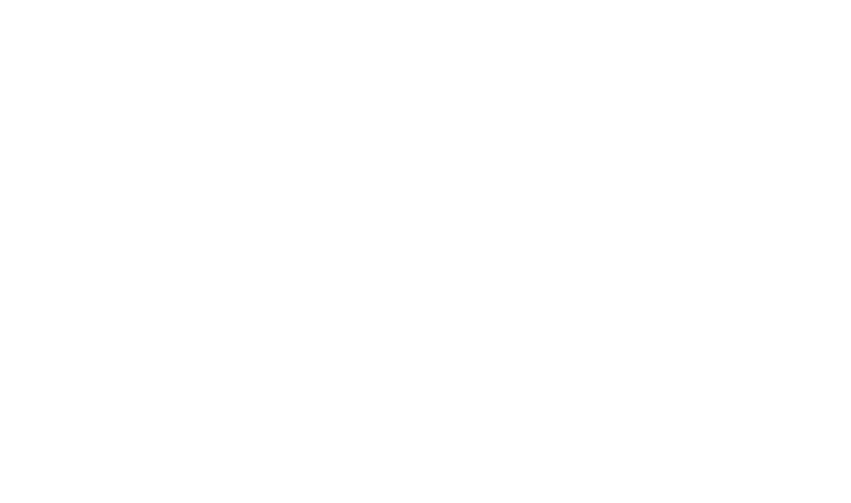

In [119]:
# Import plot_tree from sklearn.tree module.
from sklearn.tree import plot_tree

# Establish size of figure.
plt.figure(figsize = (15, 9))

# Plot our tree.
plot_tree(gs_rf.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['a','b','c','d','e','f','g','h','i','j','k','l','m'],
          filled = True);

In [120]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(gs_rf.best_estimator_, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = ['a','b','c','d','e','f','g','h','i','j','k','l','m'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

In [118]:
len(food_df['labels'].value_counts())

13

### Extra Trees

In [ ]:
et = ExtraTreesClassifier(random_state = 5,
                          class_weight = 'balanced')

In [ ]:
# gridsearch:

et_params = {
    'n_estimators' : [10, 100, 500],
    'max_features' : [None, 4, 20],
    'max_depth' : [None, 10, 20],
    'ccp_alpha' : [0, 1, 10, 0.1, 0.5, 5]
}
gs_et = GridSearchCV(et, param_grid = et_params, cv = 5)